# testing IAS_mapper::samparse 

In [ ]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

def file_len(fname):
    with open(fname, 'r') as f:
        return len(f.readlines())
    
def cigar_caller(mystring):
    mynumb = ""
    total = 0
    for char in mystring:
        if char.isdigit() == True:
            mynumb += char
        elif char == "M":
            total += int(mynumb)
            mynumb = ""
        elif char == "I":
            total -= int(mynumb)
            mynumb = ""
        elif char == "D":
            total += int(mynumb)*2
            mynumb = ""
    return total


In [ ]:
toy_data = Path("toy-data")
sam_files = [file for file in toy_data.iterdir() if file.suffix == '.sam']
print(sam_files)
irl_rt = Path('toy-data/B16-1_1-RT_IRL.sam')
irr_rt = Path('toy-data/B16-1_1-RT_IRR.sam')
irl_s = Path('toy-data/B16-1_1-S_IRL.sam')
irr_s = Path('toy-data/B16-1_1-S_IRL.sam')

In [ ]:
# TODO: decipher these flags
# https://en.wikipedia.org/wiki/SAM_(file_format)#cite_note-spec-4
read1_flags = [69,73,89,99,81,83,89]
[ print(i, bin(i)) for i in read1_flags ]
read2_flags = [161,163,169,145,147]
[ print(i, bin(i)) for i in read2_flags ]
read1_flags_pos = [69,73,89,99]
read1_flags_neg = [81,83,89]

read2_flags_pos = [161,163,169]
read2_flags_neg = [145,147]

In [ ]:
results = {}  # results[chrom:address(-/+)] = [# in IRL, # in IRR]
ligation = {}
IRLmax = 0
IRRmax = 0

file = irl_rt
linecount = file_len(file)
with open(file, "r") as SAM:
    count = 0
    count_reads = 0
    len12 = 0
    has_flags = 0
    for line1, line2 in itertools.zip_longest(SAM, SAM, fillvalue=''):
        if linecount - count > 2:
            count += 2
            count_reads += 1
            read1 = line1.split("\t")
            read2 = line2.split("\t")
            flag1 = int(read1[1])
            flag2 = int(read2[1])
            if flag1 in read1_flags:
                flag = flag1
                chrom  = read1[2]
                address = int(read1[3])
                length = cigar_caller(read1[5])
                seq = read1[9]
            elif flag2 in read1_flags:
                flag = flag2
                chrom  = read2[2]
                address = int(read2[3])
                length = cigar_caller(read2[5])
                seq = read2[9]
            else:
                # length = 0
                continue
            
            #Runs if first line contains the mapping data for the transposon read
            #Executes if transposon IRL read mapped to + strand
            has_flags += 1
            
            # there is a minimum len input for hisat2, so it has to be larger than 12
            if length >= 12:
                len12 += 1
                # if the read flag is in the positve strand
                if flag in read1_flags_pos:
                    # and the sequence starts with TA
                    if seq[0:2] == "TA":
                        # flips strand for IRL
                        tag = f"{chrom}:{address}-"
                        # add tag to results
                        if tag in results:
                            results[tag][0] += 1
                            if results[tag][0] > IRLmax:
                                IRLmax = results[tag][0]
                            mapcheck = True
                        else:
                            results[tag] = [1, 0]
                            mapcheck = True
                        # add length to ligation
                        if tag in ligation:
                            if length not in ligation[tag][0]:
                                ligation[tag][0].append(length)
                        else:
                            ligation[tag] = [[], []]
                            ligation[tag][0].append(length)
                            
                # else if the read flag is in the negative strand
                elif flag in read1_flags_neg:
                    if seq[-2:] == "TA":
                        # flips strand for IRL
                        tag = f"{chrom}:{address + (length - 2)}+"
                        if tag in results:
                            results[tag][0] += 1
                            if results[tag][0] > IRLmax:
                                IRLmax = results[tag][0]
                            mapcheck = True
                        else:
                            results[tag] = [1,0]
                            mapcheck = True
                        if tag in ligation:
                            if length not in ligation[tag][0]:
                                ligation[tag][0].append(length)
                        else:
                            ligation[tag] = [[],[]]
                            ligation[tag][0].append(length)
                
                # paired read only if the transposon read cannot be mapped precisely
                if mapcheck == False: 
                    if flag1 in read2_flags:
                        flag = flag1
                        chrom = read1[2]
                        address = read1[3]
                        length = cigar_caller(read1[5])
                        seq = read1[9]
                    elif flag2 in read2_flags:
                        flag = flag2
                        chrom = read2[2]
                        address = read2[3]
                        length = cigar_caller(read2[5])
                        seq = read2[9]
                    else:
                        continue
                    
                    if length >= 10:
                        if flag in read2_flags_pos:
                            if seq[0:2] == "TA":
                                tag = f"{chrom}:{address}-"
                                if tag in results:
                                    results[tag][0] += 1
                                    if results[tag][0] > IRLmax:
                                        IRLmax = results[tag][0]
                                    mapcheck = True
                                else:
                                    results[tag] = [1,0]
                                    mapcheck = True
                                if tag in ligation:
                                    if length not in ligation[tag][0]:
                                        ligation[tag][0].append(length)
                                else:
                                    ligation[tag] = [[],[]]
                                    ligation[tag][0].append(length)
                                    
                        elif flag in read2_flags_neg:
                            if seq[-2:] == "TA":
                                tag = f"{chrom}:{address + (length - 2)}+"
                                if tag in results:
                                    results[tag][0] += 1
                                    if results[tag][0] > IRLmax:
                                        IRLmax = results[tag][0]
                                    mapcheck = True
                                else:
                                    results[tag] = [1,0]
                                    mapcheck = True
                                if tag in ligation:
                                    if length not in ligation[tag][0]:
                                        ligation[tag][0].append(length)
                                else:
                                    ligation[tag] = [[],[]]
                                    ligation[tag][0].append(length)
print(count_reads)
print(has_flags)
print(len12)


In [ ]:
results

In [ ]:
ligation

In [ ]:
import pysam

samfile = pysam.AlignmentFile('toy-data/2020_SB_bam/B16-1_1-RT_IRL.bam')

In [ ]:
for i in samfile.head(n=2):
    print(i)

In [ ]:
for i, read in enumerate(samfile.fetch()):
    
    if read.is_paired:
        print(read)
        
    if i == 1:
        break

In [ ]:
samfile.get_index_statistics()

In [ ]:
# tuple of the lengths of the reference sequences.
# The lengths are in the same order as pysam.AlignmentFile.references
samfile.lengths

In [ ]:
samfile.references

In [ ]:
for i, read in enumerate(samfile.fetch()):
    pass

In [ ]:
# int with total number of unmapped reads according to the statistics recorded in the index.
# This number of reads includes the number of reads without coordinates. 
samfile.unmapped

In [ ]:
# int with total number of reads without coordinates according to the statistics recorded in the index
# i.e., the statistic printed for “*” by the samtools idxstats command
samfile.nocoordinate

In [ ]:
for i, read in enumerate(samfile.fetch()):
    
    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.cigarstring)
        print(read.cigartuples)
    if i == 1:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_aligned_pairs())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_cigar_stats())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_forward_qualities())

    if i == 1:
        break
    print()

In [ ]:
# Reads mapped to the reverse strand are stored reverse complemented in the BAM file.
# This method returns such reads reverse complemented back to their original orientation.

for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.seq)
        print(read.get_forward_sequence())

    if i == 1:
        break
    print()

In [ ]:
# infer read length from CIGAR alignment.
# This method deduces the read length from the CIGAR alignment including hard-clipped bases.

for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.infer_read_length())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_read1)

    if i == 10:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_read2)

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_forward)

    if i == 1:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.next_reference_start)

    if i == 1:
        break

In [ ]:
count_ta = 0
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read1:
        tmp = read.get_forward_sequence()
        if tmp[:2] =='TA':
            count_ta += 1
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read1 and not read.is_forward:
        if read.seq[-2:] == 'TA':
            print(read.is_forward)
            print(read.seq)
            print(read.get_forward_sequence())
            break

In [ ]:
count_ta = 0
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read2:
        tmp = read.get_forward_sequence()
        if tmp[:2] =='TA':
            count_ta += 1
print(i)
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)

In [ ]:
count_ta = 0
count_dis = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped:
        tmp = read.get_forward_sequence()
        if tmp[:2] == 'TA':
            count_ta += 1
    else:
        count_dis += 1
        print(read.mate_is_mapped, read.is_mapped)
        print(read.flag)
print()
print(i)
print(count_dis)
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)


In [ ]:
flags = [69, 101, 133, 165]
[ print(bin(flag)) for flag in flags ]

# build a pd.DataFrame with stats per file using pysam commands to fill out the columns

https://pysam.readthedocs.io/en/latest/api.html#api

https://en.wikipedia.org/wiki/SAM_(file_format)

Determine strand orientation using read number (read1 vs. read2) and is_forward (or is + strand)

How to link read1 to read2? samfile.mate(read)

Does cigartuples give the same as what we are expecting in cigar_caller?

Find discrepencies in samfile.mapped and samfile.fetch(). I think what is happening is one of the reads is mapped and the other paired read (mate) is unmapped

Find discrepencies in samfile.unmapped and samfile.nocoordinates. Could be the same as above

Get per contig (chromosome) stats with samfile.get_index_statistics()

Sense strand is forward, or the (+) strand

What we want to have in the dataframe...?
- mapped reads1
- mapped reads2
- mapped reads1 starts TA
- mapped reads2 starst TA
- unmapped reads1
- unmapped reads2

For each insertion

- save the transposon orientation

In [ ]:
import pysam
import pandas as pd
samfile = pysam.AlignmentFile('toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam')

In [ ]:
len([ read for i, read in enumerate(samfile.fetch()) ])

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped:
        count += 1
print(count)

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped and read.mate_is_mapped:
        count += 1
print(count)

for i, read in enumerate(samfile.fetch()):
    if read.is_mapped and read.mate_is_mapped:
        print(read.get_forward_sequence())
        print(samfile.mate(read).get_forward_sequence())
        print(read.cigartuples)
        print(samfile.mate(read).cigartuples)
    break

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if not read.is_mapped and read.mate_is_mapped:
        count += 1
print(count)

In [ ]:
# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

In [ ]:
# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion):
    res = {
        'name': [insertion.query_name],
        'chr':[refseq2chr[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],  # For IRR: + if forward, - if not. For IRL this is reversed
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


insertions = []
for i, read1 in enumerate(samfile.fetch()):
    
    # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
    if not read1.is_paired:
        continue
    
    # don't use reads that are mapped to different chroms
    if read1.reference_name != read2.reference_name:
        continue
    
    
    # only look at read 1
    if read1.is_read1:
        # if read 1 is mapped, continue with this read
        if read1.is_mapped:
            read = read1
        # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
        elif read1.mate_is_mapped:
            read = samfile.mate(read1)
        # if neither are mapped, then we won't process these paired reads
        else:
            continue
    # skip read 2 so that we aren't doubling our insertions
    else:
        continue
    
    
    # check if the contig (chromosome) is what we want
    if read.reference_name not in refseq2chr.keys():
        continue
    
    # check if read begins with TA
    if read.get_forward_sequence()[:2] == 'TA':
        insert_properties = get_insertion_properties(read)
    # if not, check if the mate read is mapped and then check if that read starts with a TA
    elif read.mate_is_mapped:
        mate_read = samfile.mate(read)
        if mate_read.get_forward_sequence()[:2] == 'TA':
            insert_properties = get_insertion_properties(mate_read)
        else:
            continue
    else:
        continue
    
    # record this as an insertion at a site
    insertions.append(insert_properties)

In [ ]:
# combine individual insertions into counts of insertions per site
insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
display(insertions_df.set_index(['chr', 'pos', 'strand +']))

In [ ]:
tmp = insertions_df.groupby(by=['chr', 'pos'], as_index=False, dropna=False)['name'].count()
tmp1 =tmp[['chr', 'pos']]
tmp1['count'] = tmp[['name']]
display(tmp1)

In [ ]:
tmp = insertions_df.groupby(by=['chr', 'pos'], as_index=False, dropna=False).mean(numeric_only=True)
int_cols = ['strand +', 'ref length', 'query length', 'read length', 'quality']
tmp[int_cols] = tmp[int_cols].astype(int)
res_df = tmp1.merge(tmp, on=['chr', 'pos'])
display(res_df)

In [ ]:
import pysam


# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion, chrdict):
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],  # TODO: For IRR: + if forward, - if not. For IRL this is reversed
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


def process_bam(bam_file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(bam_file)
    insertions = []
    for i, read1 in enumerate(samfile.fetch()):
        
        # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
        if not read1.is_paired:
            continue
        
    
        # only look at read 1
        if read1.is_read1:
            # if read 1 is mapped, continue with this read
            if read1.is_mapped:
                read = read1
            # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
            elif read1.mate_is_mapped:
                read = samfile.mate(read1)
            # if neither are mapped, then we won't process these paired reads
            else:
                continue
        # skip read 2 so that we aren't doubling our insertions
        else:
            continue
        
        
        # check if the contig (chromosome) is what we want
        if read.reference_name not in chr_dict.keys():
            continue
        
        # check if read begins with TA
        if read.get_forward_sequence()[:2] == 'TA':
            insert_properties = get_insertion_properties(read, chr_dict)
        # if not, check if the mate read is mapped and then check if that read starts with a TA
        elif read.mate_is_mapped:
            mate_read = samfile.mate(read)
            if mate_read.get_forward_sequence()[:2] == 'TA':
                insert_properties = get_insertion_properties(mate_read, chr_dict)
            else:
                continue
        else:
            continue
        
        # record this as an insertion at a site
        insertions.append(insert_properties)
        
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
    
    # group together reads that occur at the same chr, pos, and strand. Get the counts
    tmp = insertions_df.groupby(by=['chr', 'pos', 'strand +'], as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[['chr', 'pos', 'strand +']]
    tmp1['count'] = tmp[['name']]
    
    # get the mean of ref, query, read lengths and quality
    tmp = insertions_df.groupby(by=['chr', 'pos', 'strand +'], as_index=False, dropna=False).mean(numeric_only=True)
    res_df = tmp1.merge(tmp, on=['chr', 'pos', 'strand +'])
    
    return res_df


bam_irl = 'toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam'
bam_irl_df = process_bam(bam_irl, refseq2chr, False)
display(bam_irl_df)


bam_irr = 'toy-data/2020_SB-bam/B16-1_1-RT_IRR.bam'
bam_irr_df = process_bam(bam_irr, refseq2chr, True)
display(bam_irr_df)


print(bam_irl_df['count'].sum())
print(bam_irr_df['count'].sum())
print(bam_irl_df.equals(bam_irr_df))

In [ ]:
import pysam
import pandas as pd
import numpy as np

# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion, chrdict):
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'mapping quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


def process_bam(bam_file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(bam_file)
    insertions = []
    for i, read1 in enumerate(samfile.fetch()):
        
        # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
        if not read1.is_paired:
            continue
        
    
        # only look at read 1
        if read1.is_read1:
            # if read 1 is mapped, continue with this read
            if read1.is_mapped:
                read = read1
            # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
            elif read1.mate_is_mapped:
                read = samfile.mate(read1)
            # if neither are mapped, then we won't process these paired reads
            else:
                continue
        # skip read 2 so that we aren't doubling our insertions
        else:
            continue
        
        
        # check if the contig (chromosome) is what we want
        if read.reference_name not in chr_dict.keys():
            continue
        
        # check if read is forward (+) or reverse (-) and if it's IRR/IRL
        if read.is_forward:
            if is_irr:  # +, IRR, then starts with TA
                if read.get_forward_sequence()[:2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
            else:  # +, IRL, then ends with TA
                if read.get_forward_sequence()[:-2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:-2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
        else:
            if is_irr:  # -, IRR, then ends with TA
                if read.get_forward_sequence()[:-2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:-2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
            else:  # -, IRL, then starts with TA
                if read.get_forward_sequence()[:2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
        
        # record this as an insertion at a site
        insertions.append(insert_properties)
        
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
    
    # fix strand orientation depending on sequencing library
    # For IRR: + if forward, - if not. For IRL this is reversed
    if is_irr:
        insertions_df['seq library'] = 'IRR'
        insertions_df['promoter orient +'] = insertions_df['strand +']
    else:
        insertions_df['seq library'] = 'IRL'
        insertions_df['promoter orient +'] = ~insertions_df['strand +']
    
    # make the orientations easier to read (+/-)
    insertions_df['strand'] = np.where(insertions_df['strand +'], '+', '-')
    insertions_df['promoter orient'] = np.where(insertions_df['promoter orient +'], '+', '-')
    insertions_df = insertions_df.drop(['strand +', 'promoter orient +'], axis=1)
    
    
    # group together reads that occur at the same chr, pos, and strand. Get the counts.
    # TODO: should we be grouping at the strand orientation or the promotoer orientation? 
    # TODO: However in this case, we are only looking at just IRL or just IRR
    # TODO: therefore I can't see the possibilty that an inseriton can occur in the same palce in both directions
    # TODO: though theoretically possible with distinct clonal expansion...?
    group_cols = ['chr', 'pos', 'strand', 'promoter orient', 'seq library']
    
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[group_cols]
    tmp1['count'] = tmp[['name']]
    
    # get the mean of ref, query, read lengths and quality?
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).mean(numeric_only=True)
    res_df = tmp1.merge(tmp, on=group_cols)
    
    return res_df


bam_irl = 'toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam'
inserts_irl_df = process_bam(bam_irl, refseq2chr, False)

bam_irr = 'toy-data/2020_SB-bam/B16-1_1-RT_IRR.bam'
inserts_irr_df = process_bam(bam_irr, refseq2chr, True)

inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)
inserts_df = inserts_df.sort_values(['chr', 'pos'], ignore_index=True)
inserts_df['counts_irr'] = np.where(inserts_df['seq library'] == 'IRR', inserts_df['count'], 0)
inserts_df['counts_irl'] = np.where(inserts_df['seq library'] == 'IRL', inserts_df['count'], 0)
inserts_df = inserts_df[['chr', 'pos', 'promoter orient', 'counts_irr', 'counts_irl']]

display(inserts_df)





# make a col for promoter is on + strand or not
# promoter faces IRR, so IRR is + then so is promoter. maybe make this "transposon orientation, or tnp orient" and change to +/-
# and for the transposon IRL/IRR call it sequence library, maybe seq lib

# TODO: look at Aak1 in my research. do I have it? is it in the snps? is it in the pathways? where can it be found in the results?

In [ ]:
tmp = inserts_df[['chr', 'pos', 'strand', 'promoter orient', 'seq library', 'counts_irr', 'counts_irl']]
display(tmp.groupby(by=['chr', 'pos', 'promoter orient'], as_index=False, dropna=False).sum(numeric_only=True))

In [ ]:
tmp_promoter = inserts_df.groupby(by=['chr', 'pos', 'promoter orient'], as_index=False, dropna=False).sum(numeric_only=True)
display(tmp_promoter)

In [ ]:
irl_ind = inserts_irl_df['chr'] + '-' + inserts_irl_df['pos'].astype(str)
irr_ind = inserts_irr_df['chr'] + '-' + inserts_irr_df['pos'].astype(str)

np.intersect1d(irl_ind, irr_ind)

In [ ]:
print(inserts_df['count'].sum())

In [ ]:
print(len(inserts_df['pos']))
print(len(np.unique(inserts_df['pos'])))

In [ ]:
# TODO: check IRL and IRR. Why do they have the same insertons places and counts if we don't consider IRL and IRR?
# correct IRL strand orientation and collapse the IRL/IRR designation into just the insertion location
# make two columns, each is the IRL or IRR count (0 if not present, but this will appear as NaN) and then whatever is decided (take the max of the two) can be done down the line
tmp = inserts_df

tmpirr = tmp[tmp['seq library'] == 'IRR'].drop(['seq library', 'strand', 'promoter orient', 'ref length', 'query length', 'read length', 'mapping quality'], axis=1)
tmpirr.rename(columns={'count': 'count_irr'}, inplace=True)

tmpirl = tmp[tmp['seq library'] == 'IRL'].drop(['seq library', 'strand', 'promoter orient', 'ref length', 'query length', 'read length', 'mapping quality'], axis=1)
tmpirl.rename(columns={'count': 'count_irl'}, inplace=True)

tmp1 = pd.concat([tmpirr, tmpirl], ignore_index=True)
tmp1 = tmp1.fillna(0)
tmp1['count_irr'] = tmp1['count_irr'].astype(int)
tmp1['count_irl'] = tmp1['count_irl'].astype(int)
tmp1 = tmp1.sort_values(['chr', 'pos'], ignore_index=True)
print(len(tmp1))
tmp2 = tmp1.groupby(by=['chr', 'pos'], as_index=False, dropna=False).sum(numeric_only=True)
print(len(tmp2))


In [ ]:
positions, counts = np.unique(inserts_df['pos'], return_counts=True)
counts = np.array(counts)
dups = positions[counts != 1]

display(tmp2[tmp2['pos'].isin(dups)].sort_values('pos'))

# preprocess.py

In [1]:
from pathlib import Path

import pysam
import pandas as pd
import numpy as np

from IPython.display import display

# changing chromosome names
# GRCm39 https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT
chr_dict = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

In [2]:
def get_insertion_properties(insertion, chrdict):
    # record the insertions stats (direction, +/-, and all that)
    # NOTE: here is where additional statistics and or properties for each insertion site can be added
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'mapping quality': [insertion.mapping_quality],  # MAPQ: MAPping Quality.
        # MAPQ equals −10 log10 Pr{mapping position is wrong}, rounded to the nearest integer.
        # A value 255 indicates that the mapping quality is not available.
        # otherwise, the higher the number, the more confident of the quality of the mapping
        # see solution for x in wolfram
        #       254 = -10 * log10(x) 
        #       11 = -10 * log10(x)
    }
    res = pd.DataFrame.from_dict(res)
    return res


def read_is_quality(read, is_irr, chr_dict):
    # that is paired
    if not read.is_paired:
        return False
    
    # this is mapped
    if not read.is_mapped:
        return False

    # and has a contig (chromosome) is the predefined dict
    if read.reference_name not in chr_dict.keys():
        return False

    # check if read is forward (+) or reverse (-), then see if 'TA' is present with respects to IRR/IRL orientation
    if read.is_forward:
        if is_irr:  # +, IRR, then starts with TA
            if read.get_forward_sequence()[:2] == 'TA':
                return True
        else:  # +, IRL, then ends with TA
            if read.get_forward_sequence()[:-2] == 'TA':
                return True
    else:
        if is_irr:  # -, IRR, then ends with TA
            if read.get_forward_sequence()[:-2] == 'TA':
                return True
        else:  # -, IRL, then starts with TA
            if read.get_forward_sequence()[:2] == 'TA':
                return True

    return False

def process_bam(file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(file, 'rb')
    insertions = []
    for read1 in bam.fetch():  # multiple_iterators=True
        # only look at read 1
        if not read1.is_read1:
            continue
        # if the read1 is a quality read, then get the insertions properties
        if read_is_quality(read1, is_irr, chr_dict):
            insert_properties = get_insertion_properties(read1, chr_dict)
            insertions.append(insert_properties)
        # check if read 2 (the mate read) is quality and can be used for insertion properties
        else:
            # must have a mate read that is mapped for .mate() to return properly
            if read1.mate_is_unmapped or (not read1.is_paired):
                continue
            
            read2 = bam.mate(read1)

            # also check if read2 and read1 mapped to the same reference_name
            if read1.reference_name != read2.reference_name:
                continue

            # then check if the read2 is a quality read and get the insertion properties
            if read_is_quality(read2, is_irr, chr_dict):
                insert_properties = get_insertion_properties(read2, chr_dict)
                insertions.append(insert_properties)

    bam.close()
    # check if there were any inseritons at all to avoid errors from pandas.concat()
    if len(insertions) == 0:
        return None
    
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)



    # TODO: put everything below in a separate function and return insertions_df
    # set transposon promoter orientation depending on sequencing library
    # For IRR: + if forward, - if not. For IRL this is reversed
    # using 'strand +' as a cool is easy to change, but it could also have been set this way in get_insertion_properties()
    if is_irr:
        insertions_df['seq library'] = 'IRR'
        insertions_df['tpn promoter orient +'] = insertions_df['strand +']
    else:
        insertions_df['seq library'] = 'IRL'
        insertions_df['tpn promoter orient +'] = ~insertions_df['strand +']
    
    # make the orientations easier to read (+/-)
    insertions_df['strand'] = np.where(insertions_df['strand +'], '+', '-')
    insertions_df['tpn promoter orient'] = np.where(insertions_df['tpn promoter orient +'], '+', '-')
    insertions_df = insertions_df.drop(['strand +', 'tpn promoter orient +'], axis=1)
    
    # Get the counts by grouping reads that occur at the same chr, pos, strand, tpn promotoer orient, and seq library.
    group_cols = ['chr', 'pos', 'strand', 'tpn promoter orient', 'seq library']
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[group_cols]
    tmp1['count'] = tmp[['name']]
    # keep track of individual read names to ensure uniqueness of insertion sites
    tmp1['read names'] = insertions_df.groupby(by=group_cols, dropna=False)['name'].apply(list).reset_index(drop=True)
    
    
    # get the mean of ref, query, read lengths and quality
    tmp2 = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).mean(numeric_only=True)
    # change the column names to reflect the mean
    tmp2 = tmp2.rename({'ref length': 'ref length (mean)', 'query length': 'query length (mean)', 'read length': 'read length (mean)',
                      'mapping quality': 'mapping quality (mean)'}, axis=1)
    
    # also get median and stdev for mapping quality
    tmp2['mapping quality (median)'] = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).median(numeric_only=True)['mapping quality']
    tmp2['mapping quality (stdev)'] = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).std(numeric_only=True)['mapping quality']

    res_df = tmp1.merge(tmp2, on=group_cols)
    tmp_names = res_df.pop('read names')
    res_df.insert(len(res_df.columns.values), 'read names', tmp_names)
    return res_df


In [3]:
# files that encountered errors
# EL4-36_3-LT           
# B16PD1-531_2-LT       
# B16PD1-534_1-RT       
# B16-475_2-LT          
# B16-485_3-S           
# B16-516_2-RT          
# EL4-47_1-RT           

sample = "EL4-36_3-LT"
data_dir = Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/2020_SB-bam")
irl_bam = data_dir / f"{sample}_IRL.bam"
irr_bam = data_dir / f"{sample}_IRR.bam"


# resolve IRR and IRL files and convert them to single insertion site format
inserts_irl_df = process_bam(file=irl_bam, chr_dict=chr_dict, is_irr=False)
if inserts_irl_df is not None:  # if no insertions present, process_bam returns None
    inserts_irl_df['seq library'] = 'IRL'

inserts_irr_df = process_bam(file=irr_bam, chr_dict=chr_dict, is_irr=True)
if inserts_irr_df is not None:  # if no insertions present, process_bam returns None
    inserts_irr_df['seq library'] = 'IRR'

# concat of a dataframe and None just results in the original dataframe
inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)
inserts_df = inserts_df.sort_values(['chr', 'pos'], ignore_index=True)

# get seq library specific counts
count_irr = np.where(inserts_df['seq library'] == 'IRR', inserts_df['count'], 0)
count_irl = np.where(inserts_df['seq library'] == 'IRL', inserts_df['count'], 0)
inserts_df.insert(6, "count_irr", count_irr)
inserts_df.insert(7, "count_irl", count_irl)
tmp_read_name = inserts_df.pop('read names')
inserts_df.insert(len(inserts_df.columns.values), "read names", tmp_read_name)

# verify that insertions did not count both read1 and read2
# do this by checking that the length of 'read names'is the same number as the length of unique read names
read_names = inserts_df['read names'].to_numpy()
for i in range(len(read_names)):
    sample = read_names[i]
    assert len(np.unique(sample)) == len(sample)
        
# show total irr and irl conuts
print(f"irr insertions: {inserts_df['count_irr'].sum()}")
print(f"irl insertions: {inserts_df['count_irl'].sum()}")

display(inserts_df)

irr insertions: 3598
irl insertions: 1338


,chr,pos,strand,tpn promoter orient,seq library,count,count_irr,count_irl,ref length (mean),query length (mean),read length (mean),mapping quality (mean),mapping quality (median),mapping quality (stdev),read names
0,chr1,4291905,+,+,IRR,23,23,0,112.739130,147.913043,147.913043,33.260870,36.0,3.933740,"[K00274:76:HHHM2BBXX:8:1106:28818:10739, K0027..."
1,chr1,4958166,+,+,IRR,4,4,0,69.500000,151.000000,151.000000,32.000000,32.0,4.618802,"[K00274:76:HHHM2BBXX:8:1108:5467:14273, K00274..."
2,chr1,5507834,+,+,IRR,1,1,0,113.000000,148.000000,148.000000,42.000000,42.0,NaN,[K00274:76:HHHM2BBXX:8:2103:26484:31664]
3,chr1,6326891,+,+,IRR,13,13,0,112.846154,147.846154,147.846154,33.923077,36.0,4.329387,"[K00274:76:HHHM2BBXX:8:1116:13017:39207, K0027..."
4,chr1,6658404,-,+,IRL,1,0,1,70.000000,148.000000,148.000000,0.000000,0.0,NaN,[K00274:76:HHHM2BBXX:8:2221:4858:40016]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,chrX,160442081,+,+,IRR,1,1,0,75.000000,148.000000,148.000000,24.000000,24.0,NaN,[K00274:76:HHHM2BBXX:8:1210:3599:17860]
1240,chrX,160639864,+,+,IRR,6,6,0,113.000000,148.000000,148.000000,42.000000,42.0,0.000000,"[K00274:76:HHHM2BBXX:8:1225:21623:27145, K0027..."
1241,chrX,168457184,+,+,IRR,1,1,0,40.000000,148.000000,148.000000,22.000000,22.0,NaN,[K00274:76:HHHM2BBXX:8:1117:3305:37501]
1242,chrX,168773874,-,+,IRL,1,0,1,111.000000,148.000000,148.000000,1.000000,1.0,NaN,[K00274:76:HHHM2BBXX:8:1220:25510:15135]


# main.py

In [1]:
from pathlib import Path

from docopt import docopt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

# from importlib import reload
from IPython.display import display

In [2]:
args = {
    'dir': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/2020_SB-insertions'),
    'meta': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/meta_insertions.csv'),
    'output': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/output'),
    'verbose': 1,
    'jobs': 8,
    'rand_state': 42,
}

## load data

In [3]:
# load meta data of insertion files
# this is implemented so that additional meta information can be added by a user in the future
meta_df = pd.read_csv(args['meta'])
display(meta_df)

,file name,cell type,cell id,tumor type
0,EL4PD1-113_1-RT.csv,EL4PD1,113_1,RT
1,EL4PD1-113_1-LT.csv,EL4PD1,113_1,LT
2,EL4PD1-113_2-LT.csv,EL4PD1,113_2,LT
3,EL4PD1-119_1-LT.csv,EL4PD1,119_1,LT
4,EL4PD1-119_1-RT.csv,EL4PD1,119_1,RT
...,...,...,...,...
307,EL4-64_1-RT.csv,EL4,64_1,RT
308,EL4-64_2-LT.csv,EL4,64_2,LT
309,EL4-64_2-RT.csv,EL4,64_2,RT
310,EL4-68_1-RT.csv,EL4,68_1,RT


In [4]:
# load insertion data files
# add meta info
insert_list = []
for file in args['dir'].iterdir():
    file_meta_info = meta_df.loc[meta_df['file name'] == file.name].drop('file name', axis=1)
    tmp_df = pd.read_csv(file)
    tmp_df['cell type'] = file_meta_info['cell type'].tolist()[0]
    tmp_df['cell id'] = file_meta_info['cell id'].tolist()[0]
    tmp_df['tumor type'] = file_meta_info['tumor type'].tolist()[0]
    insert_list.append(tmp_df)
inserts_df = pd.concat(insert_list, ignore_index=True)
display(inserts_df)

,chr,pos,ref length,query length,read length,mapping quality,strand,tpn promoter orient,seq library,read name,cell type,cell id,tumor type
0,chr1,15274141,46,148,148,22,-,+,IRL,K00275:54:HHHJTBBXX:7:1116:23064:39910,B16,484_4,S
1,chr1,15274141,46,148,148,22,-,+,IRL,K00275:54:HHHJTBBXX:7:2111:6106:6378,B16,484_4,S
2,chr1,16839832,37,148,148,0,-,+,IRL,K00275:54:HHHJTBBXX:7:1216:31558:47102,B16,484_4,S
3,chr1,17453525,32,148,148,2,-,+,IRL,K00275:54:HHHJTBBXX:7:1210:13727:37273,B16,484_4,S
4,chr1,23220580,68,151,151,2,-,+,IRL,K00275:54:HHHJTBBXX:7:2117:21856:34723,B16,484_4,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738845,chrY,7731340,30,148,148,22,+,+,IRR,K00275:54:HHHJTBBXX:8:1222:15686:6097,B16,16_1,LT
2738846,chrY,48869516,30,148,148,22,+,+,IRR,K00275:54:HHHJTBBXX:8:2121:9394:33105,B16,16_1,LT
2738847,chrY,73689029,31,148,148,22,+,+,IRR,K00275:54:HHHJTBBXX:8:1125:6268:17772,B16,16_1,LT
2738848,chrY,78232696,30,148,148,22,+,+,IRR,K00275:54:HHHJTBBXX:8:1207:31182:23065,B16,16_1,LT


## separate data into case/controls and combine insertions

Group at the chr, pos, and tpn promoter orientation level. Keep count, count_irr and count_irl

Other method for grouping (such as per cell type or per treatment) is also possible here

In [5]:
# group_cols gives unique insertion counts, irregardless of irr/irl library
group_cols = ['chr', 'pos', 'tpn promoter orient']
keep_cols = ['count', 'count_irr', 'count_irl']

insert_case = inserts_df[inserts_df['tumor type'] == 'S']
insert_case_grouped = insert_case.groupby(by=group_cols, as_index=False, dropna=False).sum(numeric_only=True)[group_cols + keep_cols]
display(insert_case_grouped)

insert_control = inserts_df[inserts_df['tumor type'] != 'S']
insert_control_grouped = insert_control.groupby(by=group_cols, as_index=False, dropna=False).sum(numeric_only=True)[group_cols + keep_cols]
display(insert_control_grouped)


,chr,pos,tpn promoter orient,count,count_irr,count_irl
0,chr1,3112646,+,1,1,0
1,chr1,3112809,+,1,1,0
2,chr1,3196359,+,20,0,20
3,chr1,3196360,+,24,0,24
4,chr1,3196361,+,20,0,20
...,...,...,...,...,...,...
81288,chrY,90206108,+,1,0,1
81289,chrY,90445130,+,1,1,0
81290,chrY,90445638,+,1,1,0
81291,chrY,90489872,+,10,0,10


,chr,pos,tpn promoter orient,count,count_irr,count_irl
0,chr1,3066580,+,1,0,1
1,chr1,3085444,+,3,3,0
2,chr1,3112197,+,1,1,0
3,chr1,3131023,+,1,1,0
4,chr1,3158351,+,1,1,0
...,...,...,...,...,...,...
76065,chrY,90798826,+,2,2,0
76066,chrY,90803636,+,1,0,1
76067,chrY,90803643,+,2,2,0
76068,chrY,90803714,+,5,5,0


There are some instances where insertions occur both in irl and irr, but to the extent that they occur in equal amounts is not clear

This should be further investigated in what irl and irr have these odd properties together. See investigate_irr_irl.ipynb

In [6]:
tmp1 = insert_case_grouped[(insert_case_grouped['count_irr'] != 0) & (insert_case_grouped['count_irl'] != 0)]
display(tmp1)

tmp2 = insert_control_grouped[(insert_control_grouped['count_irr'] != 0) & (insert_control_grouped['count_irl'] != 0)]
display(tmp2)

,chr,pos,tpn promoter orient,count,count_irr,count_irl
169,chr1,6391684,+,16,15,1
344,chr1,9796200,+,451,450,1
404,chr1,11513901,+,100,1,99
411,chr1,11639549,+,15,13,2
719,chr1,16839832,+,39,2,37
...,...,...,...,...,...,...
79733,chrY,32154387,+,11,1,10
79816,chrY,35254072,+,2,1,1
80027,chrY,42994788,+,36,34,2
80031,chrY,42999378,+,3,2,1


,chr,pos,tpn promoter orient,count,count_irr,count_irl
229,chr1,8387338,+,3,2,1
305,chr1,11605697,+,28,26,2
308,chr1,11605709,+,3,2,1
346,chr1,12762471,+,12,11,1
421,chr1,15834327,+,8,1,7
...,...,...,...,...,...,...
74901,chrX,160442042,+,26,25,1
75095,chrX,169258182,+,2,1,1
75382,chrY,21835891,+,2,1,1
75471,chrY,29700467,+,3,1,2


## Construct graph (network) of insertions

In [17]:
from multiprocessing import Pool

def create_graph_helper(other_node, new_node, thres, graph):
    # find distance between nodes using their position
    node_dist = abs(other_node - new_node)
    # don't add edge to self
    if node_dist == 0:
        return 
    # if distance between node(i) and node(j) is less than threshold
    if node_dist <= thres:
        # add edge(ij) with a weight of the distance (or inverse?) to the network
        graph.add_edge(new_node, other_node, weight=1/node_dist)

def create_graph(insertions_df, chrom, threshold=50000):
    G = nx.Graph()
    chrom_df = insertions_df[insertions_df['chr'] == chrom].sort_values('pos')

    # for each insertion
    for i in range(len(chrom_df.index)):
        insert = chrom_df.iloc[i]
        new_node = insert['pos']
        # add node(i) as an insertion location into the network
        G.add_node(new_node,
                counts=insert['count'],
                counts_irr=insert['count_irr'],
                counts_irl=insert['count_irl'],
                orient=insert['tpn promoter orient'],
                chrom=insert['chr'],
                position=insert['pos'],
        )
        
        for other_node in G.nodes:
            # find distance between nodes using their position
            node_dist = abs(other_node - new_node)
            # don't add edge to self
            if node_dist == 0:
                continue 
            # if distance between node(i) and node(j) is less than threshold
            if node_dist <= threshold:
                # add edge(ij) with a weight of the distance (or inverse?) to the network
                G.add_edge(new_node, other_node, weight=1/node_dist)
        
    return G


In [19]:
chrom_list = np.unique(inserts_df['chr'].to_numpy())
for chrom in chrom_list:
    case_graph = create_graph(insertions_df=insert_case_grouped, chrom=chrom, threshold=50000)
    control_graph = create_graph(insertions_df=insert_control_grouped, chrom=chrom, threshold=50000)
    
    # export graphs
    out_dir = args['output']
    nx.write_graphml(case_graph, out_dir / f'case-{chrom}.graphml')
    nx.write_graphml(control_graph, out_dir / f'control-{chrom}.graphml')
# full run in 2m 46s

# Analysis

In [17]:
import seaborn.objects as so
import matplotlib.pyplot as plt

In [18]:
def graph_properties(G):
    print(f"number of nodes: {G.number_of_nodes()}")
    print(f"number of edges: {G.number_of_edges()}")
    num_inserts = 0
    for node in G.nodes:
        num_inserts += G.nodes[node]['counts']
    print(f"number of insertions: {num_inserts}")

In [19]:
G = nx.read_graphml(args['output'] / 'case-chr1.graphml')
graph_properties(G)

number of nodes: 9664
number of edges: 46836
number of insertions: 203741


In [20]:
subgraphs_by_nodes = sorted(nx.connected_components(G), key=len, reverse=True)
num_subgraphs = len(subgraphs_by_nodes)
num_subgraphs

1133

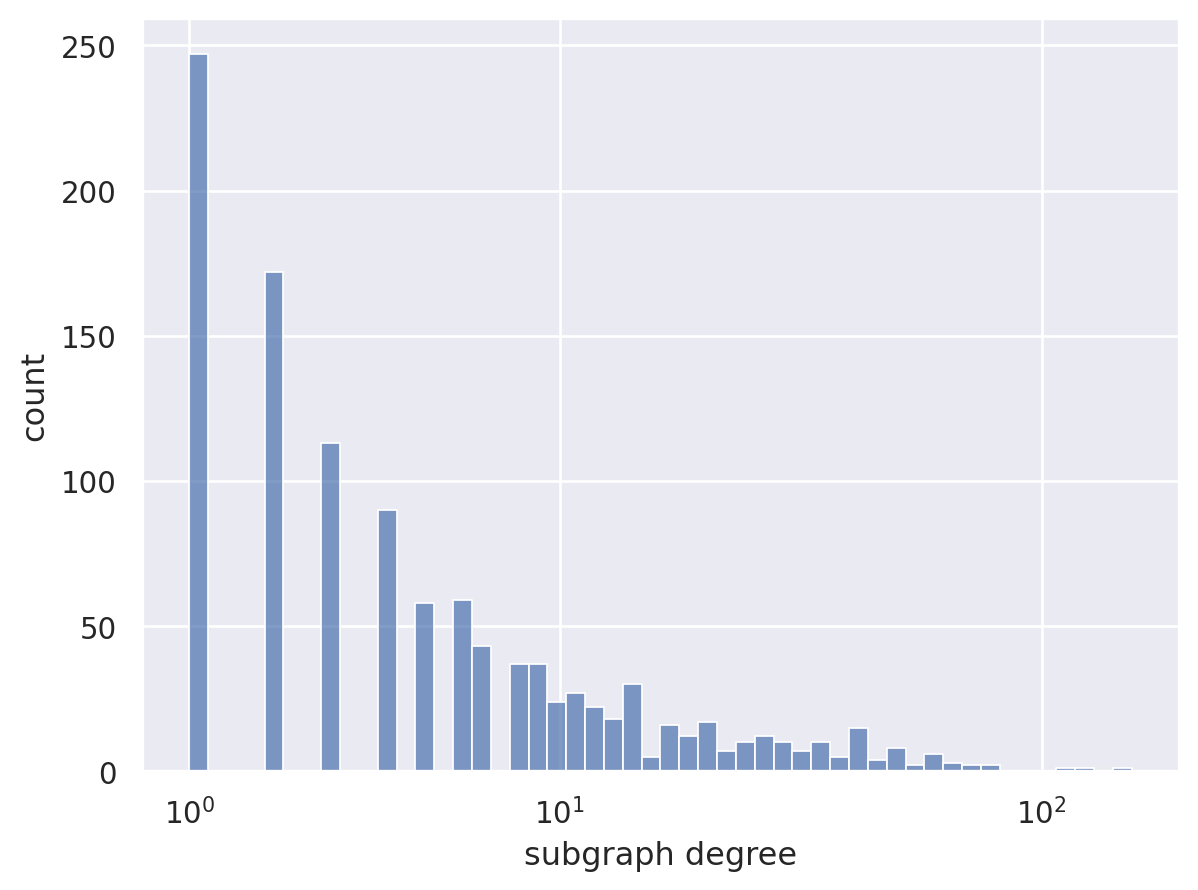

In [21]:
subgraph_degrees = [ len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True) ]
(
    so.Plot(x=subgraph_degrees)
    .add(so.Bars(), so.Hist(bins=50))
    .scale(x="symlog")
    .label(x='subgraph degree', y='count')
)

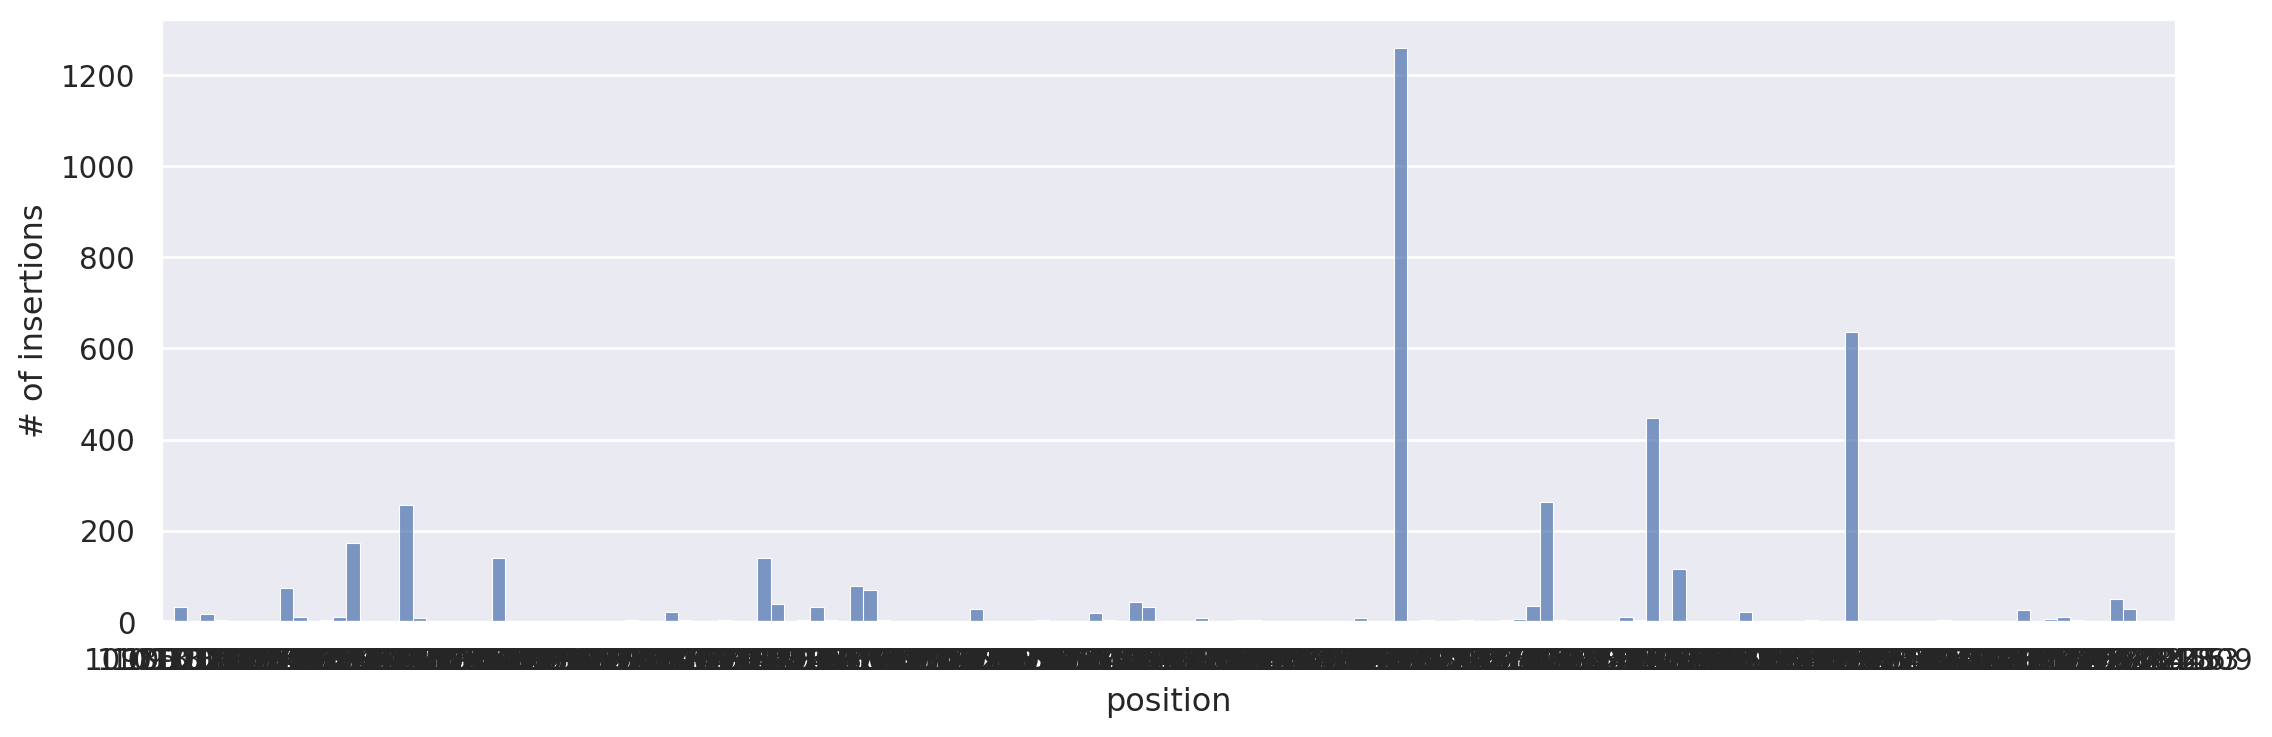

In [25]:
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]
(
    so.Plot(y=node_size, x=list(subgraphs_by_nodes[0]))
    .add(so.Bars())
    .label(x='position', y='# of insertions')
    .layout(size=(12, 4))
)

# TODO: check if the nodes are sorted by name (genomic position) 
# maybe make pandas DataFrame?

In [14]:
tmp_subgraph = G.subgraph(subgraphs_by_nodes[0])

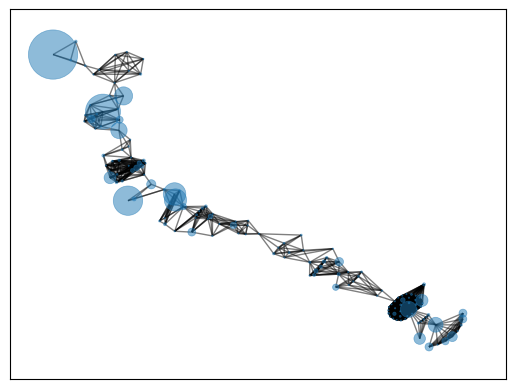

In [15]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
pos = nx.kamada_kawai_layout(tmp_subgraph)
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]
nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5)

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> None

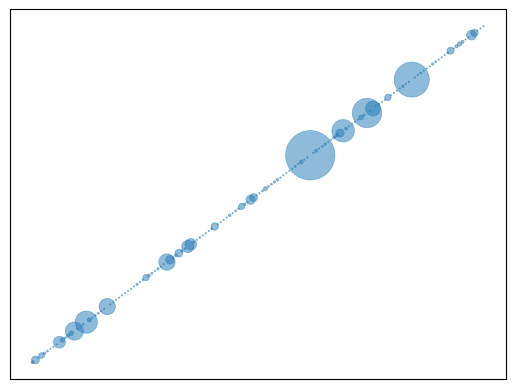

In [16]:
pos = nx.kamada_kawai_layout(tmp_subgraph)
for node, [x, y] in pos.items():
    pos[node] = [node, y]
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]

fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5, ax=ax)
ticks = np.arange(min(pos.keys())-10000, max(pos.keys())+1000, 10000)
# ax.set_xticks(ticks)
ax.grid(axis='x')

plt.show()

In [ ]:
import pygraphviz as pgv
test = nx.nx_agraph.to_agraph(tmp_subgraph)
test.layout()

In [ ]:
# analyze subgraphs

# histogram of subgraph orders

# preprocessing_reads

In [7]:
from pathlib import Path
import sys
import os

import pandas as pd
from IPython.display import display


data_dir = Path("toy-data/2020_SB-fastq")
output_prefix = "toy-data/2020_SB"
genome_index_dir = "/project/cs-myers/MathewF/software/bowtie2-2.4.5/indexes/GRCm39/GRCm39"
N = 8
input_files = "toy-data/input.tsv"

In [8]:
files_df = pd.read_csv(input_files, sep="\t", header=None)
display(files_df)

,0,1,2,3,4
0,B16-1_1-RT,1-1_RT_20170405000_20170405000_S384_L008_R1_00...,1-1_RT_20170405000_20170405000_S384_L008_R2_00...,1-1_RT_20170405001_20170405000_S465_L008_R1_00...,1-1_RT_20170405001_20170405000_S465_L008_R2_00...
1,B16-1_1-S,1-1_S_20170405000_20170405000_S382_L008_R1_001...,1-1_S_20170405000_20170405000_S382_L008_R2_001...,1-1_S_20170405001_20170405000_S463_L008_R1_001...,1-1_S_20170405001_20170405000_S463_L008_R2_001...


In [9]:
bam_output_dir = Path(output_prefix + "-bam")
bam_output_dir.mkdir(parents=True, exist_ok=True)

insertions_output_dir = Path(output_prefix + "-insertions")
insertions_output_dir.mkdir(parents=True, exist_ok=True)

In [12]:
# TODO: use multiprocessing here. No additional threads for bowtie2
for row in files_df.iterrows():
    row = row[1]
    mysample = row[0]
    irl_F = data_dir / row[1]
    irl_R = data_dir / row[2]
    irr_F = data_dir / row[3]
    irr_R = data_dir / row[4]
    
    # Process IRL reads ---> trim adaptor ---> map reads
    # append temp names to the files
    trim_irl_f1 = data_dir / (
        irl_F.name.rstrip("".join(irl_F.suffixes)) + "-5trim" + "".join(irl_F.suffixes)
    )
    trim_irl_r1 = data_dir / (
        irl_R.name.rstrip("".join(irl_R.suffixes)) + "-5trim" + "".join(irl_R.suffixes)
    )

    trim_irl_f2 = data_dir / (
        irl_F.name.rstrip("".join(irl_F.suffixes)) + "-53trim" + "".join(irl_F.suffixes)
    )
    trim_irl_r2 = data_dir / (
        irl_R.name.rstrip("".join(irl_R.suffixes)) + "-53trim" + "".join(irl_R.suffixes)
    )

    trim_irl_f3 = data_dir / (
        irl_F.name.rstrip("".join(irl_F.suffixes)) + "-trim" + "".join(irl_F.suffixes)
    )
    trim_irl_r3 = data_dir / (
        irl_R.name.rstrip("".join(irl_R.suffixes)) + "-trim" + "".join(irl_R.suffixes)
    )

    irl_sam = bam_output_dir / (mysample + "_IRL.sam")
    irl_bam = bam_output_dir / (mysample + "_IRL.bam")

    # https://cutadapt.readthedocs.io/en/stable/guide.html#id4
    # --front or -g
    # -G is for read 2
    # # -g is found by regular 5': Full adapter sequence anywhere, Partial adapter sequence at 5’ end, Full adapter sequence at 5’ end
    # # -g ^ is found by anchored 5': Full adapter sequence at 5’ end
    os.system(f"cutadapt --quiet -j {N} --discard-untrimmed -g GTATGTAAACTTCCGACTTCAACTG -o {trim_irl_f1} -p {trim_irl_r1} {irl_F} {irl_R}")

    os.system(f"cutadapt --quiet -j {N} -G ^GTAATACGACTCACTATAGGGCTCCGCTTAAGGGAC -o {trim_irl_f2} -p {trim_irl_r2} {trim_irl_f1} {trim_irl_r1}")
    os.system(f"rm {trim_irl_f1}")
    os.system(f"rm {trim_irl_r1}")

    # --adapter or -a
    # -A is for read 2
    # -a is found by regular 3: Full adapter sequence anywhere, Partial adapter sequence at 3’ end, Full adapter sequence at 3’ end
    os.system(f"cutadapt --quiet -j {N} -a GTCCCTTAAGCGGAGCCCTATAGTGAGTCGTATTAC -A CAGTTGAAGTCGGAAGTTTACATAC -o {trim_irl_f3} -p {trim_irl_r3} {trim_irl_f2} {trim_irl_r2}")
    os.system(f"rm {trim_irl_f2}")
    os.system(f"rm {trim_irl_r2}")

    os.system(f"bowtie2 -p {N} --local --quiet -x {genome_index_dir} -q -1 {trim_irl_f3} -2 {trim_irl_r3} -S {irl_sam}")
    os.system(f"rm {trim_irl_f3}")
    os.system(f"rm {trim_irl_r3}")

    os.system(f"samtools sort -@ {N} -m 4G -l 9 -o {irl_bam} {irl_sam}")
    os.system(f"samtools index -@ {N} {irl_bam}")
    os.system(f"rm {irl_sam}")

    # Process IRR reads ---> trim adaptor ---> map reads
    trim_irr_f1 = data_dir / (
        irr_F.name.rstrip("".join(irr_F.suffixes)) + "-5trim" + "".join(irr_F.suffixes)
    )
    trim_irr_r1 = data_dir / (
        irr_R.name.rstrip("".join(irr_R.suffixes)) + "-5trim" + "".join(irr_R.suffixes)
    )

    trim_irr_f2 = data_dir / (
        irr_F.name.rstrip("".join(irr_F.suffixes)) + "-53trim" + "".join(irr_F.suffixes)
    )
    trim_irr_r2 = data_dir / (
        irr_R.name.rstrip("".join(irr_R.suffixes)) + "-53trim" + "".join(irr_R.suffixes)
    )

    trim_irr_f3 = data_dir / (
        irr_F.name.rstrip("".join(irr_F.suffixes)) + "-trim" + "".join(irr_F.suffixes)
    )
    trim_irr_r3 = data_dir / (
        irr_R.name.rstrip("".join(irr_R.suffixes)) + "-trim" + "".join(irr_R.suffixes)
    )
    irr_sam = bam_output_dir / (mysample + "_IRR.sam")
    irr_bam = bam_output_dir / (mysample + "_IRR.bam")

    os.system(f"cutadapt --quiet -j {N} --discard-untrimmed -g GTATGTAAACTTCCGACTTCAACTG -o {trim_irr_f1} -p {trim_irr_r1} {irr_F} {irr_R}")

    os.system(f"cutadapt --quiet -j {N} -G ^GTAATACGACTCACTATAGGGCTCCGCTTAAGGGAC -o {trim_irr_f2} -p {trim_irr_r2} {trim_irr_f1} {trim_irr_r1}")
    os.system(f"rm {trim_irr_f1}")
    os.system(f"rm {trim_irr_r1}")

    os.system(f"cutadapt --quiet -j {N} -a GTCCCTTAAGCGGAGCCCTATAGTGAGTCGTATTAC -A CAGTTGAAGTCGGAAGTTTACATAC -o {trim_irr_f3} -p {trim_irr_r3} {trim_irr_f2} {trim_irr_r2}")
    os.system(f"rm {trim_irr_f2}")
    os.system(f"rm {trim_irr_r2}")

    os.system(f"bowtie2 -p {N} --local --quiet -x {genome_index_dir} -q -1 {trim_irr_f3} -2 {trim_irr_r3} -S {irr_sam}")
    os.system(f"rm {trim_irr_f3}")
    os.system(f"rm {trim_irr_r3}")

    os.system(f"samtools sort -@ {N} -m 4G -l 9 -o {irr_bam} {irr_sam}")
    os.system(f"samtools index -@ {N} {irr_bam}")
    os.system(f"rm {irr_sam}")


[bam_sort_core] merging from 0 files and 8 in-memory blocks...
[bam_sort_core] merging from 0 files and 8 in-memory blocks...
[bam_sort_core] merging from 0 files and 8 in-memory blocks...
[bam_sort_core] merging from 0 files and 8 in-memory blocks...
